In [2]:
import h5py
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense  
from keras import backend as K
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import pandas as pd
import tables
import matplotlib.pyplot as plt
import tensorflow as tf
import preprocessing
import matplotlib as mpl

In [ ]:
model = keras.models.load_model('./models/final_model/')
batch_size = 100

Importing the data and extracting the high level variables, jet variables, key names, weights, and labels. Then organising into dictionaries and splitting in the same way as in the training notebook. Finally it turns the split data into a tensorflow dataset as it runs faster on those (i think).

In [4]:
dataPath = '/path/to/test.h5'
with h5py.File(dataPath, 'r') as data:

    npDataLabels = np.array(data['labels'])

    npDataWeights = np.array(data['weights'])

    jetVars = {key: data[key][...] for key in data.attrs.get('jet')}
    
    hlDataArr = {key: data[key][...] for key in data.attrs.get('hl')}

    hlKeys = data.attrs.get('hl')

processed_dict = preprocessing.high_level(hlDataArr)
processed_df = pd.DataFrame(processed_dict)

jetVarsArr = [val for val in jetVars.values()]
jetVarsDf = pd.DataFrame(np.stack(jetVarsArr, axis=-1))

data_train, data_test, labels_train, labels_test, weights_train, weights_test, jetVars_train, jetVars_test = train_test_split(processed_df, npDataLabels, npDataWeights, jetVarsDf, test_size=0.33, random_state=69, shuffle=True)

test_data_set = tf.data.Dataset.from_tensor_slices((data_test, labels_test, weights_test)).batch(batch_size)

## Now to start analysing

In [5]:
testPreds = model.predict(test_data_set)

8198/8198 [==============================] - 12s 1ms/step


Here we're just putting everything into a nice pretty dataframe to make things easier down the line

In [7]:
data_test_new = data_test.copy()
data_test_new['labels'] = labels_test
data_test_new['weights'] = weights_test
data_test_new['predictions'] = testPreds
data_test_new['jet_pt'] = jetVars_test[0]
data_test_new['jet_eta'] = jetVars_test[1]
data_test_new['jet_phi'] = jetVars_test[2]
data_test_new['jet_m'] = jetVars_test[3]


In [8]:
binary_predictions = []
for i in data_test_new['predictions']:
    if i <= 0.5:
        binary_predictions.append(0)
    else:
        binary_predictions.append(1)

data_test_new['binary_predictions'] = np.array(binary_predictions)


In [9]:
renameDict = {i: hlKeys[i] for i in range(15)}
data_test_new.rename(renameDict, axis='columns', inplace=True)

In [10]:
sigIndices = data_test_new['labels'] == 1
bkgIndices = data_test_new['labels'] == 0

In [11]:
conf_matrix = metrics.confusion_matrix(data_test_new['labels'], data_test_new['binary_predictions'], labels=[1,0])
print(conf_matrix)

[[367092  42453]
 [ 80269 329945]]


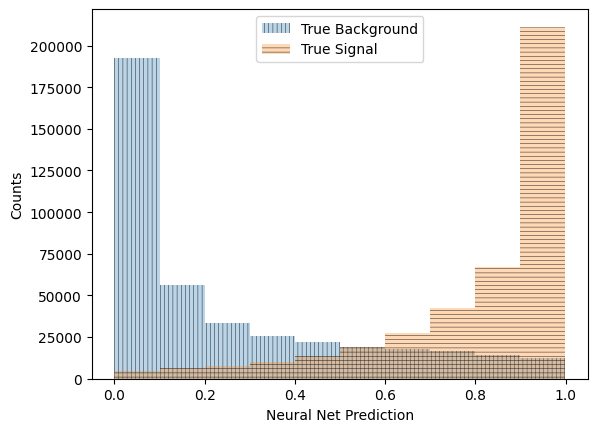

In [13]:
plt.figure()
plt.xlabel('Neural Net Prediction')
plt.ylabel('Counts')

bkgHist = plt.hist(data_test_new['predictions'][bkgIndices], bins=10, label='True Background', alpha=0.3, hatch='||||')
sigHist = plt.hist(data_test_new['predictions'][sigIndices], bins=10, label='True Signal', alpha=0.3, hatch='----')

plt.legend()
mpl.rcParams['hatch.linewidth'] = 0.3
plt.savefig('bkg_vs_signal.pdf')
plt.show() 

Splitting into high and low pT and analysing

In [14]:
pt_midpoint = min(data_test_new['jet_pt']) + (min(data_test_new['jet_pt']) + max(data_test_new['jet_pt'])) / 2

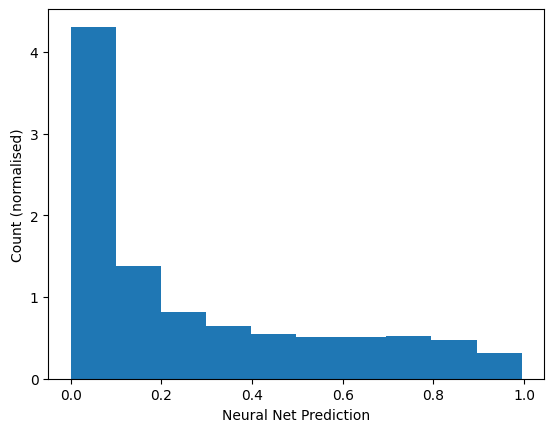

In [15]:
plt.figure()
plt.hist(data_test_new.loc[(data_test_new['labels'] == 0) & (data_test_new['jet_pt'] > pt_midpoint), 'predictions'], density=True)
plt.xlabel('Neural Net Prediction')
plt.ylabel('Count (normalised)')
plt.savefig('bkg_high_pt.pdf')
plt.show()

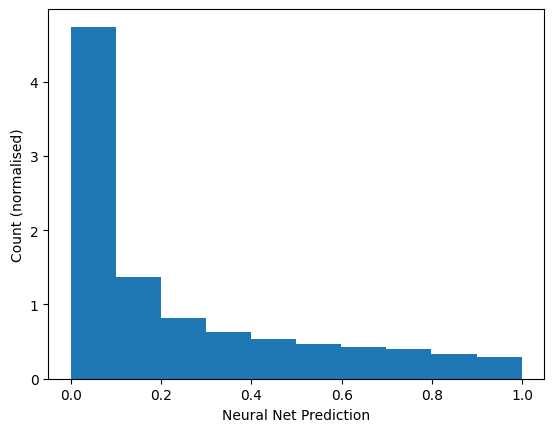

In [16]:
plt.figure()
plt.hist(data_test_new.loc[(data_test_new['labels'] == 0) & (data_test_new['jet_pt'] <= pt_midpoint), 'predictions'], density=True)
plt.xlabel('Neural Net Prediction')
plt.ylabel('Count (normalised)')
plt.savefig('bkg_low_pt.pdf')
plt.show()

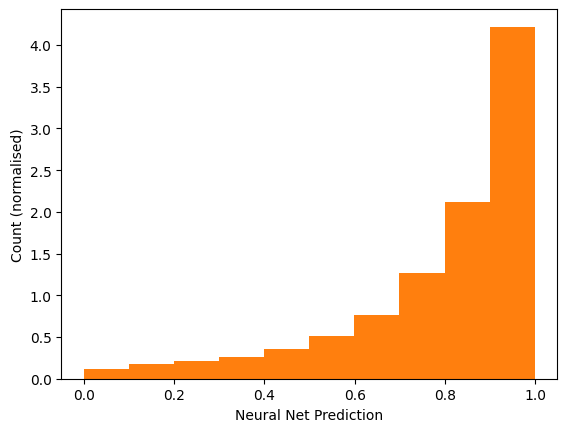

In [17]:
plt.figure()
plt.hist(data_test_new.loc[(data_test_new['labels'] == 1) & (data_test_new['jet_pt'] > pt_midpoint), 'predictions'], density=True, color='C1')
plt.xlabel('Neural Net Prediction')
plt.ylabel('Count (normalised)')
plt.savefig('sig_high_pt.pdf')
plt.show()

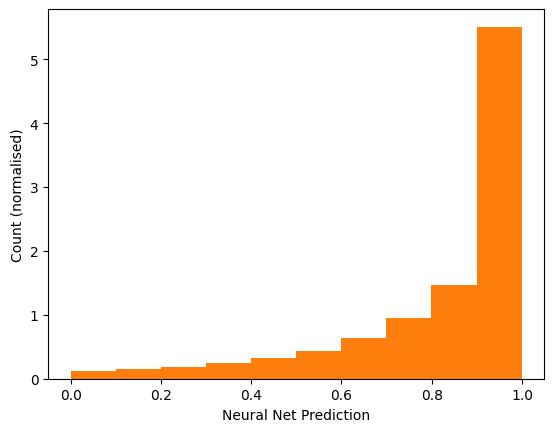

In [18]:
plt.figure()
plt.hist(data_test_new.loc[(data_test_new['labels'] == 1) & (data_test_new['jet_pt'] <= pt_midpoint), 'predictions'], density=True, color='C1')
plt.xlabel('Neural Net Prediction')
plt.ylabel('Count (normalised)')
plt.savefig('sig_low_pt.pdf')
plt.show()

Finding PPV, NPV, and ACC for the high pT, low pT, and then for the entire set

In [30]:
conf_matrix_2 = metrics.confusion_matrix(data_test_new.loc[(data_test_new['jet_pt'] > pt_midpoint), 'labels'], data_test_new.loc[(data_test_new['jet_pt'] > pt_midpoint), 'binary_predictions'], labels=[1,0])
PPV_high = conf_matrix_2[0,0]/(conf_matrix_2[0,0]+conf_matrix_2[1,0])
NPV_high = conf_matrix_2[1,1]/(conf_matrix_2[1,1]+conf_matrix_2[0,1])
ACC_high = (conf_matrix_2[0,0] + conf_matrix_2[1,1]) / (conf_matrix_2[0,0]+conf_matrix_2[0,1]+conf_matrix_2[1,0]+conf_matrix_2[1,1])
print(f'PPV: {PPV_high}\nNPV: {NPV_high}\nACC: {ACC_high}')

PPV: 0.9089274561386906
NPV: 0.7247422445774632
ACC: 0.8548368769676027


In [29]:
conf_matrix_3 = metrics.confusion_matrix(data_test_new.loc[(data_test_new['jet_pt'] <= pt_midpoint), 'labels'], data_test_new.loc[(data_test_new['jet_pt'] <= pt_midpoint), 'binary_predictions'], labels=[1,0])
PPV_low = conf_matrix_3[0,0]/(conf_matrix_3[0,0]+conf_matrix_3[1,0])
NPV_low = conf_matrix_3[1,1]/(conf_matrix_3[1,1]+conf_matrix_3[0,1])
ACC_low = (conf_matrix_3[0,0] + conf_matrix_3[1,1]) / (conf_matrix_3[0,0]+conf_matrix_3[0,1]+conf_matrix_3[1,0]+conf_matrix_3[1,1])
print(f'PPV: {PPV_low}\nNPV: {NPV_low}\nACC: {ACC_low}')

PPV: 0.7932464506990315
NPV: 0.9075719796261961
ACC: 0.8492810543342665


In [31]:
# conf_matrix_2 = metrics.confusion_matrix(data_test_new.loc[(data_test_new['jet_pt'] <= pt_midpoint), 'labels'], data_test_new.loc[(data_test_new['jet_pt'] <= pt_midpoint), 'binary_predictions'], labels=[1,0])
PPV = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[1,0])
NPV = conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[0,1])
ACC = (conf_matrix[0,0] + conf_matrix[1,1]) / (conf_matrix[0,0]+conf_matrix[0,1]+conf_matrix[1,0]+conf_matrix[1,1])
print(f'PPV: {PPV}\nNPV: {NPV}\nACC: {ACC}')

PPV: 0.8205722000800248
NPV: 0.886000998931251
ACC: 0.8502950257331728
